* 複数のマイクロホンでの音声の収録をシミュレーションで実現
* 音が音源からマイクに伝わるまでの伝播モデルは、以下の畳み込み混合モデルで記述できる$$x_t = \sum_{\tau=0}^{L-1} h_\tau s_{t-\tau}$$
  * $s_t$: 音源信号
  * $x_t$: マイクロホン入力信号
  * $h_\tau$: 音源からマイクに音が伝わるまでに、どのくらい減衰・遅延するかを表す係数、インパルス応答と呼ばれる
* インパルス応答では、直接音の成分と減衰と遅延を表す係数は $h_\tau$
* 直接音以外にも、壁や床で反射して様々な音がマイクに伝わる（反響音、残響音）
* インパルス応答は、瞬間的に音量が大きくなるパルス信号だが、それをスピーカーから出すのは非現実的
* 実際にはパルス信号を時間方向に伸ばした TSP (Time Stretched Pulse) 信号をスピーカーから出す
* 音源分離を試したい環境で TSP 法などで収録したインパルス応答が事前に用意されていると仮定
* このとき、インパルス応答を上式に基づき音源信号に掛ける（畳み込む）ことで、あたかもインパルス応答を収録した環境で収録したかのような音を生成できる
* SciPy でもインパルス応答の畳み込みのための関数が用意されている

In [1]:
import wave
import pyroomacoustics as pa
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Audio

np.random.seed(0)

clean_wave_file = "../arctic_a0001.wav"

In [2]:
def plot_spectrogram(data_list, sample_rate):
    """データからスペクトログラムを作成し、それをプロットする関数

    Parameters:
    data_list: list of numpy array
        音声データのリスト
    sample_rate: int
        サンプリングレート（Hz）
    """
    n = len(data_list)
    fig, axs = plt.subplots(1, n, figsize=(10 * n, 4))

    # リスト内の各データに対してスペクトログラムを生成
    for i in range(n):
        data = data_list[i]
        spectrum, freqs, t, im = axs[i].specgram(data, NFFT=512, noverlap=int(512 / 16 * 15), Fs=sample_rate, cmap="gray")
        fig.colorbar(im, ax=axs[i]).set_label("Intensity [dB]")
        axs[i].set_xlabel("Time [sec]")
        axs[i].set_ylabel("Frequency [Hz]")

    plt.tight_layout()
    plt.show()

In [3]:
with wave.open(clean_wave_file) as wav:
    data = wav.readframes(wav.getnframes())
    data = np.frombuffer(data, dtype=np.int16)
    data = data / np.iinfo(np.int16).max

# サンプリング周波数
sample_rate = 16000
# 畳み込むインパルス応答長
n_impulse_length = 512

# インパルス応答を乱数で生成（ダミー）
impulse_response = np.random.normal(size=n_impulse_length)

conv_data = signal.convolve(data, impulse_response, mode="full")

data_scale_adjust = conv_data * np.iinfo(np.int16).max / 20.0
data_scale_adjust = data_scale_adjust.astype(np.int16)

Audio(data_scale_adjust, rate=sample_rate)

* mode パラメータ：インパルス応答を畳み込んだ後の出力波形を途中で打ち切るかどうかを決めるパラメータ
  * 畳み込んだ後の出力波形は、元の音声よりも (インパルス応答の長さ - 1) サンプル分だけ長くなっている
  * 長くなった分を打ち切りたい場合は、mode="same" とする
  * mode="full" は打ち切らずに、長くなった分も出力する
* 様々なな今日で実測したインパルス応答を用意し、音源信号に畳み込むことで、それらと同じ環境で収録したかのような音をシミュレーションで作り出せる
* ただし、実測したインパルス応答では、残響の量や、音源とマイクの位置関係を変えられない
* バリエーションを増やすためのシミュレータの一つとして、Pyroomacoustics を使用し、室内伝達関数のシミュレーションをしてみる
* 室内伝達関数のシミュレーションでは、音の入射角と反射角が等しくなることを利用し、仮想的な部屋を折り返し作り、音の反射を模擬する（鏡像法）

In [4]:
# 畳み込みに用いる音声波形
clean_wave_files = ["../arctic_a0001.wav", "../arctic_a0002.wav"]

# 音源数
n_sources = len(clean_wave_files)

# 長さを調べる
n_samples = []
# ファイルを読み込む
for clean_wave_file in clean_wave_files:
    with wave.open(clean_wave_file) as wav:
        n_samples.append(wav.getnframes())

# ファイルから読み込んだ音声を格納
clean_data = np.zeros([n_sources, max(n_samples)])
for i, clean_wave_file in enumerate(clean_wave_files):
    with wave.open(clean_wave_file) as wav:
        data = wav.readframes(wav.getnframes())
        data = np.frombuffer(data, dtype=np.int16)
        data = data / np.iinfo(np.int16).max
        clean_data[i, :wav.getnframes()] = data

シミュレーションのパラメータ

* 10 m 立方体の部屋
* max_order: 音の反射回数
* absorption: 部屋の壁の吸音率
* 今回は、max_order=0 として反射は考えておらず、直接音だけをシミュレート
* add_microphone_array でマイクの配置と fs (frequency of sampling) を指定

In [5]:
# サンプリング周波数
sample_rate = 16000

# 音声と雑音との比率 [dB]
SNR = 90.0

# 部屋の大きさ
room_dim = np.r_[10.0, 10.0, 10.0]

# マイクロホンアレイを置く部屋の場所
mic_array_loc = room_dim / 2 + np.random.randn(3) * 0.1
print(f"{mic_array_loc=}")

# マイクロホンアレイのマイク配置
mic_alignments = np.array(
    [
        [-0.01, 0.0, 0.0],
        [0.01, 0.0, 0.0],
    ]
)

# マイクロホン数
n_channels = np.shape(mic_alignments)[0]
print(f"{n_channels=}")

# マイクロホンアレイの座標系
R = mic_alignments.T + mic_array_loc[:, None]
print(f"{R=}")

# 部屋を生成する
room = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)
print(f"{room=}")

# マイクロホンアレイの情報を設定する
room.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))

# 音源の場所
doas = np.array([[np.pi / 2.0, 0], [np.pi / 2.0, np.pi / 2.0]])
print(f"{doas=}")

# 音源とマイクロホンの距離
distance = 1.0
source_locations = np.zeros((3, doas.shape[0]), dtype=doas.dtype)
source_locations[0, :] = np.cos(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[1, :] = np.sin(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[2, :] = np.cos(doas[:, 0])
source_locations *= distance
source_locations += mic_array_loc[:, None]

mic_array_loc=array([4.86677883, 4.80313753, 4.93399437])
n_channels=2
R=array([[4.85677883, 4.87677883],
       [4.80313753, 4.80313753],
       [4.93399437, 4.93399437]])
room=<pyroomacoustics.room.ShoeBox object at 0x00000204AEC43280>
doas=array([[1.57079633, 0.        ],
       [1.57079633, 1.57079633]])


* add_source で音源の情報を設定
  * source_location: 音源の 3 次元位置
  * signal: 音源信号
* SNR (Signal to Noise Ratio) は、音源以外の雑音と音源信号の比率を表す指標$$SNR = 10 \log_{10} \frac{\sum_{t} s_t^2}{\sum_{t} n_t^2}$$
  * $s_t$: 音源の時間領域の信号
  * $n_t$: 雑音の時間領域の信号
* SNR が大きいほど雑音の影響が少なく、小さいほど雑音の影響が大きい
* 今回は雑音を想定していないため、90 dB と音源が支配的になるように設定されている

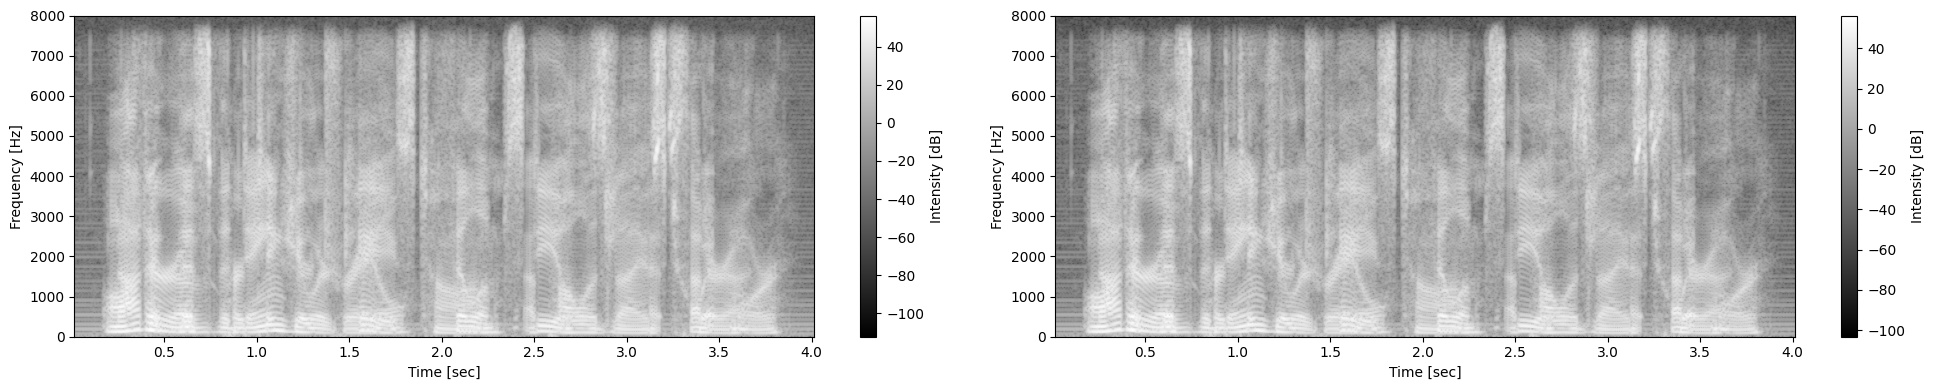

In [6]:
# 各音源をシミュレーションに追加する
for s in range(n_sources):
    clean_data[s] /= np.std(clean_data[s])
    room.add_source(source_locations[:, s], signal=clean_data[s])

# シミュレーションを回す
room.simulate(snr=SNR)

# 畳み込んだ波形を取得する(チャンネル、サンプル）
multi_conv_data = room.mic_array.signals

def process_and_display_audio(multi_conv_data, n_channels, sample_rate):
    """マルチチャンネルの畳み込みデータをオーディオとして処理し、表示する。
    また、全てのオーディオデータのスペクトログラムを描画する。

    Parameters:
    multi_conv_data: numpy array
        マルチチャンネルの畳み込みデータ
    n_channels: int
        チャンネル数
    sample_rate: int
        サンプリングレート（Hz）
    """
    sound_data = []
    for m in range(n_channels):
        conv_data = multi_conv_data[m, :]
        data_scale_adjust = conv_data * np.iinfo(np.int16).max / 20.0
        data_scale_adjust = data_scale_adjust.astype(np.int16)
        sound_data.append(data_scale_adjust)
        display(Audio(data_scale_adjust, rate=sample_rate))
    plot_spectrogram(sound_data, sample_rate)

process_and_display_audio(multi_conv_data, n_channels, sample_rate)

* 残響の量を変更
* max_order を 0 より大きい値に設定することで、反射音を模擬
* absorption を 0.35 として、壁である程度音が吸収されるように設定
* 無残響環境のスペクトログラムと比較して、残響の影響で音声が時間方向ににじんでいることがわかる

c:\Users\MK\workspace\python-source-separation\myenv\lib\site-packages\matplotlib\axes\_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


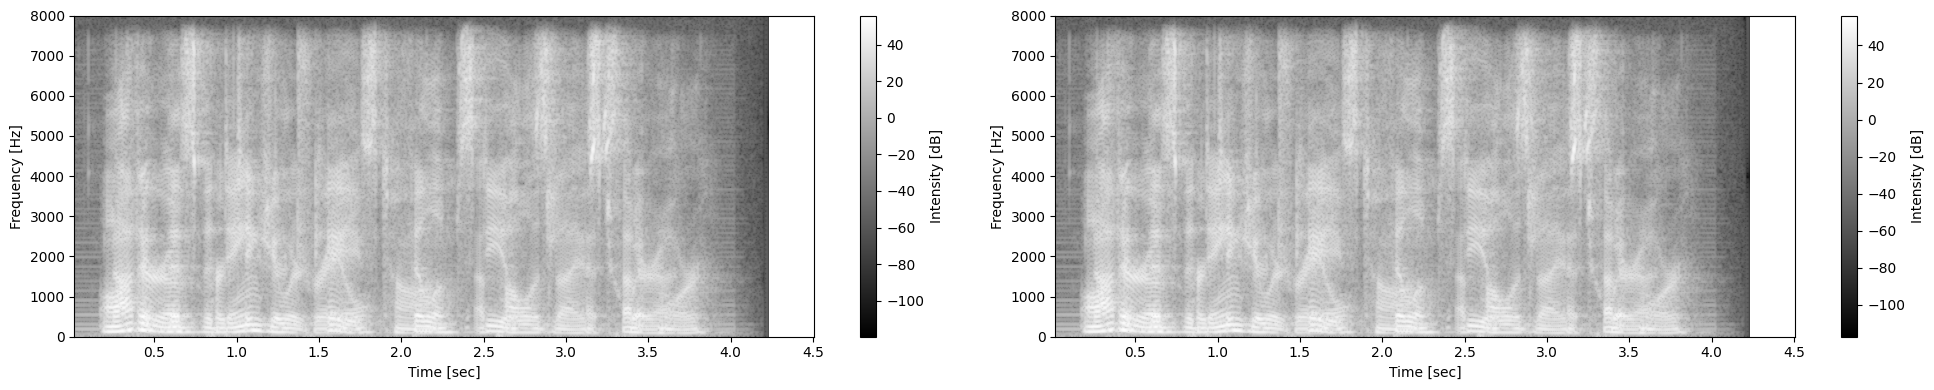

In [7]:
room_reverb = pa.ShoeBox(room_dim, fs=sample_rate, max_order=17, absorption=0.35)
room_reverb.add_microphone_array(pa.MicrophoneArray(R, fs=room_reverb.fs))

for s in range(n_sources):
    clean_data[s] /= np.std(clean_data[s])
    room_reverb.add_source(source_locations[:, s], signal=clean_data[s])

room_reverb.simulate(snr=SNR)
multi_conv_data = room_reverb.mic_array.signals

process_and_display_audio(multi_conv_data, n_channels, sample_rate)

次に SNR を 10 dB に変更してみる

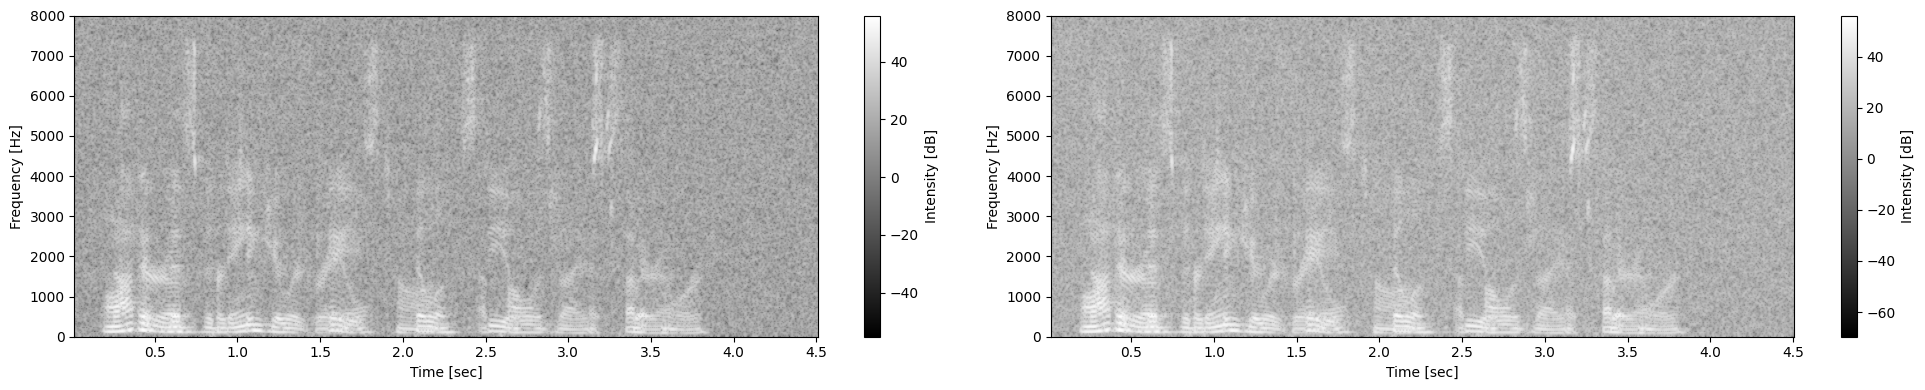

In [8]:
SNR = 10.0
room_reverb.simulate(snr=SNR)
multi_conv_data = room_reverb.mic_array.signals

process_and_display_audio(multi_conv_data, n_channels, sample_rate)

* 雑音に音声成分（特に残響成分）が埋もれている
* Pyroomacoustics では、インパルス応答の生成とインパルス応答を残響のない信号に畳み込んだ信号の生成を両方同時に行える

残響時間: 0.3469375 [sec]


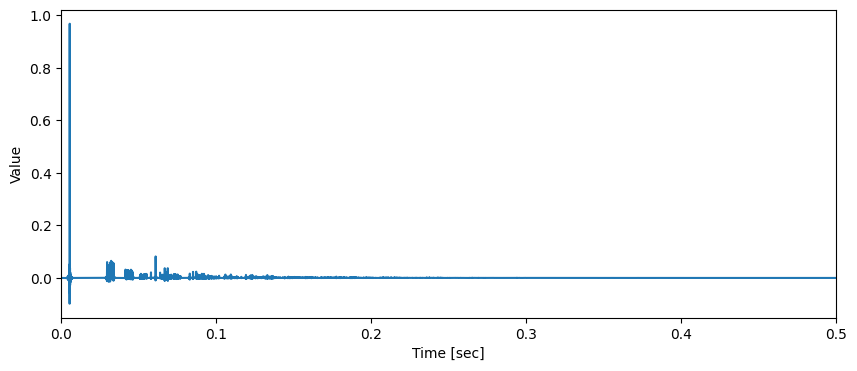

In [9]:
SNR = 90.0
room_reverb.simulate(snr=SNR)

# インパルス応答を取得する
# room.rirにはマイク，音源の順番で各音源の各マイクのインパルス応答が入っている
impulse_responses = room_reverb.rir

impulse_length = np.shape(impulse_responses[0][0])[0]

# 残響時間を取得
rt60 = pa.experimental.measure_rt60(impulse_responses[0][0], fs=sample_rate)
print(f"残響時間: {rt60} [sec]")

# 音声データをプロットする
x = np.array(range(impulse_length)) / sample_rate
plt.figure(figsize=(10, 4))
plt.xlabel("Time [sec]")
plt.ylabel("Value")
plt.xlim([0, 0.5])
plt.plot(x, impulse_responses[0][0])

* インパルス応答は room.rir にマイク数 * 音源数分だけ入っている
* 最初のインデックスはマイクのインデックス、次のインデックスは音源のインデックス
* ここでは一つ目の音源の一つ目のマイクロホンのインパルス応答を取り出している
* 残響時間：発話し終わってから残響が消えるまでの時間
* RT60 (Reverberation Time 60 dB)：残響時間が 60 dB 減衰するまでの時間
* 最も早い時間に届いているパルス信号が音源からマイクまで直接届く成分
* そのあともう少し時間が空いて、最初の音よりも小さい音が届いている（反射音、残響音）
* 距離が長い分、音は減衰し、壁などでも吸収されるため、直接音より音量が小さくなる

C:\Users\MK\AppData\Local\Temp\ipykernel_8256\3506319568.py:5: RuntimeWarning: divide by zero encountered in log10
  reverb_power[t] = 10.0 * np.log10(np.sum(rir_power[t:]) / np.sum(rir_power))


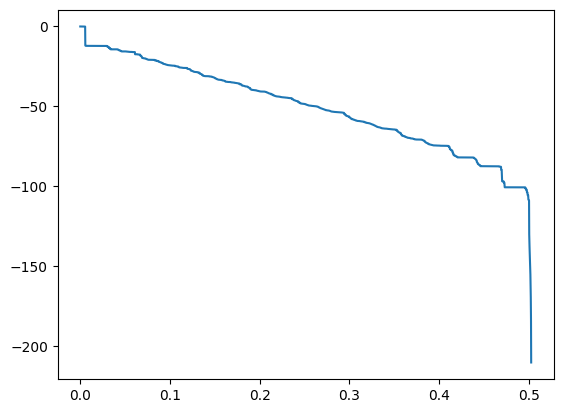

In [10]:
rir_power = np.square(impulse_responses[0][0])

reverb_power = np.zeros_like(rir_power)
for t in range(impulse_length):
    reverb_power[t] = 10.0 * np.log10(np.sum(rir_power[t:]) / np.sum(rir_power))

plt.plot(x,reverb_power)

残響時間: 0.676875 [sec]


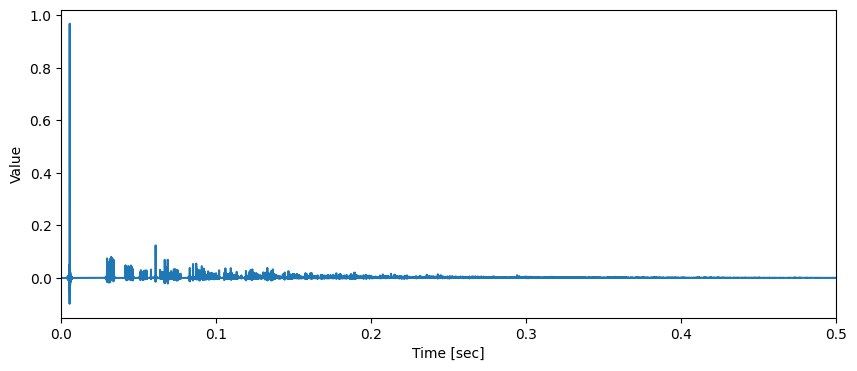

In [11]:
SNR = 90.0
room_reverb_l = pa.ShoeBox(room_dim, fs=sample_rate, max_order=30, absorption=0.2)
room_reverb_l.add_microphone_array(pa.MicrophoneArray(R, fs=room_reverb_l.fs))

for s in range(n_sources):
    clean_data[s] /= np.std(clean_data[s])
    room_reverb_l.add_source(source_locations[:, s], signal=clean_data[s])

room_reverb_l.simulate(snr=SNR)

# インパルス応答を取得する
# room.rirにはマイク，音源の順番で各音源の各マイクのインパルス応答が入っている
impulse_responses = room_reverb_l.rir

impulse_length = np.shape(impulse_responses[0][0])[0]

# 残響時間を取得
rt60 = pa.experimental.measure_rt60(impulse_responses[0][0], fs=sample_rate)
print(f"残響時間: {rt60} [sec]")

# 音声データをプロットする
x = np.array(range(impulse_length)) / sample_rate
plt.figure(figsize=(10, 4))
plt.xlabel("Time [sec]")
plt.ylabel("Value")
plt.xlim([0, 0.5])
plt.plot(x, impulse_responses[0][0])

max_order（音の反射回数）を増やし、absorption（部屋の壁の吸音率）を下げることで、残響時間が 0.35 秒から 0.7 秒に増える